In [212]:
import random
import torch
from torch.utils.data import DataLoader
from ImageAestheticsGANs.AADB.AADB import AADB, AADB_binaries
from tqdm import tqdm
from ImageAestheticsGANs.utils.utils import *
from ImageAestheticsGANs.models.ResNet18 import RegressionNetwork

In [213]:
data_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'

In [214]:
aadb = AADB_binaries(data_path, 256)
aadb_test = AADB_binaries(data_path, 256, test=True)
n_classes = aadb.get_num_classes()

In [215]:
def get_default_device():
    '''Pick GPU if available'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True).to(torch.float32)

In [216]:
class DeviceDataLoader():
    def __init__(self, dl ,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [217]:
device = get_default_device()

# Verification

In [223]:
ckpt = 'F:\Projects\Disertatie\RESULTS\\resnet18_classification\standard\AADB_epoch_190_accuracy_0.7064_.pt'

In [224]:
batch_size = 64

In [225]:
model = RegressionNetwork(backbone='resnet18', num_attributes=n_classes, pretrained=True)
model = model.to('cuda')
model.load_state_dict(torch.load(ckpt)['model'])
# batch_size = torch.load(ckpt)['batch_size']
model.eval()

RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [226]:
test_dl = DataLoader(aadb_test, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
test_dl = DeviceDataLoader(test_dl, device)

In [227]:
correct = 0
total = 0
with torch.no_grad():
    for batch, (images, labels) in tqdm(enumerate(test_dl), total=len(test_dl)):

        outputs = model(images)

        predicted = outputs > 0.5

        correct += (predicted == labels.type(torch.uint8)).sum().item()
        total += len(labels) * n_classes

    accuracy = correct / total
    print('Accuracy of all test images: %.3f' % (accuracy * 100))

100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

Accuracy of all test images: 71.355


In [228]:
def plot_loss(train_losses, val_losses):
    train_losses_list = [i.item() for i in train_losses]
    val_losses_list = [i.item() for i in val_losses]
    plt.plot(train_losses_list, '-bx')
    plt.plot(val_losses_list, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training'])
    plt.title('Loss vs No. of epochs')

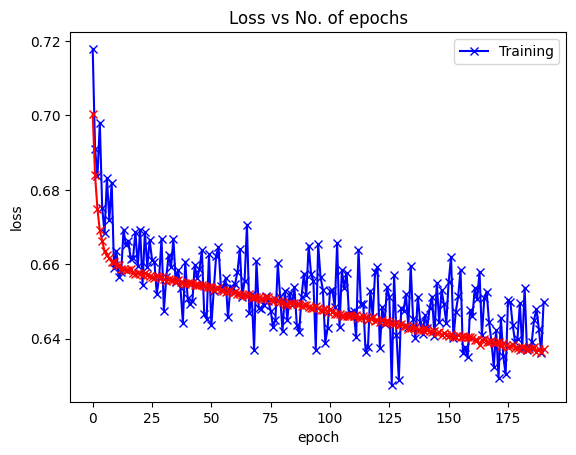

In [229]:
checkpoint = torch.load(ckpt)
train_losses = torch.load(ckpt)['train_losses']
val_losses = torch.load(ckpt)['val_losses']
plot_loss(train_losses, val_losses)

# Application

In [246]:
i = random.randint(0, len(aadb_test))
x, y = aadb[i]
x_tensor = x.to("cuda").unsqueeze(0)
y_pred = model(x_tensor)    #.cpu().detach().numpy()
print(y_pred)
predicted = y_pred > 0.5
# print(predicted)
predicted = predicted.cpu().detach().numpy()
print(predicted)
y = y.numpy()
print(y)

tensor([1.9308e-03, 4.3102e-02, 4.2928e-02, 1.2471e-03, 8.4329e-03, 9.9836e-01,
        5.4460e-02, 4.6757e-04, 4.9579e-01, 8.0184e-04, 1.8796e-01],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
[False False False False False  True False False False False False]
[0 0 0 0 0 1 1 1 0 0 1]


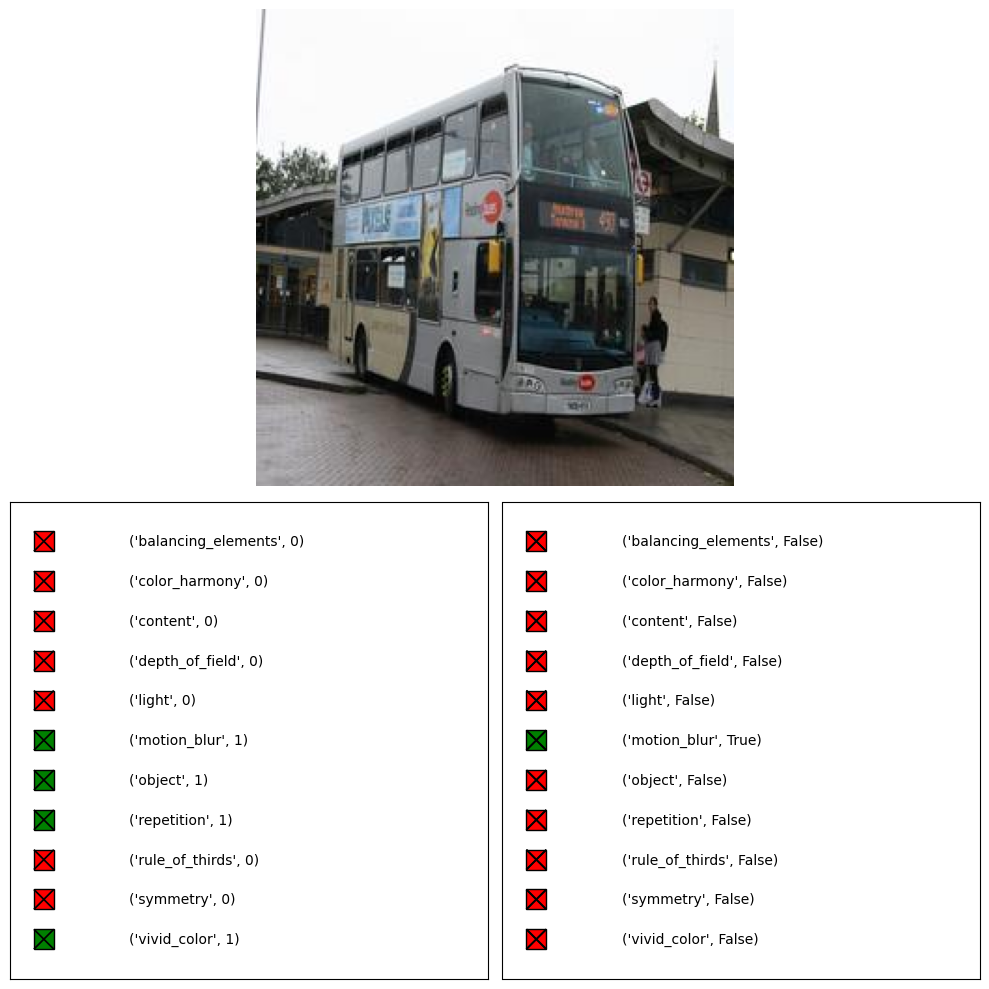

In [247]:
display_aesthetics(x, y, predicted, interval=[0, 0], score=False)